#### Resoorces: https://cs231n.github.io/transfer-learning/#tf

#### Transfer learning make use of the knowledge gained while solving one problem and applying it to a different but related problem.

For example, knowledge gained while learning to recognize cars can be used to some extent to recognize trucks.



#### feature extractor

Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.
##### Example

Take a ConvNet pretrained on ImageNet, remove the last fully-connected layer (this layer’s outputs are the 1000 class scores for a different task like ImageNet), then treat the rest of the ConvNet as a fixed feature extractor for the new dataset.

#### Fine Tuning

in Fine-tuning the second strategy is to not only replace and retrain the classifier on top of the Net on the new dataset, but to also fine-tune the weights of the pretrained network by continuing the backpropagation.

#### Pre-Training

When we train the network on a large dataset(for example: ImageNet) , we train all the parameters of the neural network and therefore the model is learned. It may take hours on your GPU.


* If the new dataset is very small, it’s better to train only the final layers of the network to avoid overfitting, keeping all other layers fixed. So remove the final layers of the pre-trained network. Add new layers . Retrain only the new layers.

* If the new dataset is very much large, retrain the whole network with initial weights from the pretrained model.

![img.png](https://miro.medium.com/max/875/1*9GTEzcO8KxxrfutmtsPs3Q.png)

![img.png](https://miro.medium.com/max/875/1*Ww3AMxZeoiB84GVSRBr4Bw.png)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())

True
GeForce GTX 1650


In [3]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [5]:
data_transforms

{'train': Compose(
     RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
     RandomHorizontalFlip(p=0.5)
     ToTensor()
     Normalize(mean=[0.5 0.5 0.5], std=[0.25 0.25 0.25])
 ),
 'val': Compose(
     Resize(size=256, interpolation=PIL.Image.BILINEAR)
     CenterCrop(size=(224, 224))
     ToTensor()
     Normalize(mean=[0.5 0.5 0.5], std=[0.25 0.25 0.25])
 )}

In [6]:
data_dir = './hymenoptera_data'

In [7]:
# defined train and test image folder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

In [8]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 244
     Root Location: ./hymenoptera_data\train
     Transforms (if any): Compose(
                              RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                              RandomHorizontalFlip(p=0.5)
                              ToTensor()
                              Normalize(mean=[0.5 0.5 0.5], std=[0.25 0.25 0.25])
                          )
     Target Transforms (if any): None,
 'val': Dataset ImageFolder
     Number of datapoints: 153
     Root Location: ./hymenoptera_data\val
     Transforms (if any): Compose(
                              Resize(size=256, interpolation=PIL.Image.BILINEAR)
                              CenterCrop(size=(224, 224))
                              ToTensor()
                              Normalize(mean=[0.5 0.5 0.5], std=[0.25 0.25 0.25])
                          )
     Target Transforms (if any): None}

In [9]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x1e92e9cc668>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x1e92e9cc6d8>}

In [10]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)
class_names = image_datasets['train'].classes
print(class_names)

{'train': 244, 'val': 153}
['ants', 'bees']


In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [12]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

In [13]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

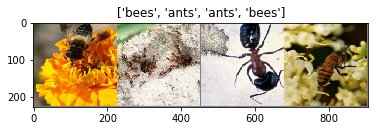

In [14]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

#### Finetuning the convnet

In [17]:
#### Finetuning the convnet ####
# Load a pretrained model and reset final fully connected layer.

model = models.resnet18(pretrained=True)
print(model)
num_ftrs = model.fc.in_features
print(num_ftrs)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\Uttam/.cache\torch\checkpoints\resnet18-5c106cde.pth
100.0%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 2)
print(model.fc)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
print(criterion)

Linear(in_features=512, out_features=2, bias=True)
CrossEntropyLoss()


In [19]:
# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001)

print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [20]:
# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
print(step_lr_scheduler)
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6123 Acc: 0.6721
val Loss: 0.4848 Acc: 0.7516

Epoch 1/24
----------
train Loss: 0.5516 Acc: 0.7500
val Loss: 0.3629 Acc: 0.9020

Epoch 2/24
----------
train Loss: 0.5043 Acc: 0.7623
val Loss: 0.3013 Acc: 0.8954

Epoch 3/24
----------
train Loss: 0.4086 Acc: 0.8443
val Loss: 0.2657 Acc: 0.9020

Epoch 4/24
----------
train Loss: 0.4582 Acc: 0.7746
val Loss: 0.2339 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.3879 Acc: 0.8238
val Loss: 0.2311 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.3926 Acc: 0.7910
val Loss: 0.2154 Acc: 0.9150

Epoch 7/24
----------
train Loss: 0.3890 Acc: 0.8197
val Loss: 0.2153 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.4018 Acc: 0.7992
val Loss: 0.2200 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.3398 Acc: 0.8484
val Loss: 0.2200 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.3875 Acc: 0.8320
val Loss: 0.2058 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3319 Acc: 0.8525
val Loss: 0.2057 Acc: 0.9150

Ep

#### ConvNet as fixed feature extractor

In [21]:

# Here, we need to freeze all the network except the final layer.
# We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()
model_conv = torchvision.models.resnet18(pretrained=True)
print(model_conv)
for param in model_conv.parameters():
    param.requires_grad = False

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
print(num_ftrs)


512


In [23]:
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

In [24]:
# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6694 Acc: 0.6639
val Loss: 0.2306 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.7072 Acc: 0.7172
val Loss: 0.1960 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.4637 Acc: 0.8033
val Loss: 0.4491 Acc: 0.7974

Epoch 3/24
----------
train Loss: 0.5383 Acc: 0.7664
val Loss: 0.1927 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.4192 Acc: 0.8156
val Loss: 0.1800 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.5447 Acc: 0.7828
val Loss: 0.4543 Acc: 0.8235

Epoch 6/24
----------
train Loss: 0.3986 Acc: 0.8074
val Loss: 0.2028 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.4212 Acc: 0.8115
val Loss: 0.1892 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.4065 Acc: 0.8197
val Loss: 0.2011 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.4618 Acc: 0.8074
val Loss: 0.1976 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3277 Acc: 0.8730
val Loss: 0.2109 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.4159 Acc: 0.8279
val Loss: 0.2045 Acc: 0.9281

Ep